In [ ]:
import numpy as np

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [ ]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [ ]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """

        # Your code goes here. ################################################
        if len(self.modules) == 0:
            self.output = input
            return self.output

        self.output = self.modules[0].forward(input)
        for module in self.modules[1:]:
            self.output = module.forward(self.output)

        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        # Your code goes here. ################################################
        outputs = [input]  # Store all intermediate outputs
        current_output = input
        for module in self.modules[:-1]:
            current_output = module.forward(current_output)
            outputs.append(current_output)

        # Then do backward pass in reverse order
        current_grad = gradOutput
        for i in reversed(range(1, len(self.modules))):
            current_grad = self.modules[i].backward(outputs[i], current_grad)

        # Finally compute gradient for first module
        self.gradInput = self.modules[0].backward(input, current_grad)

        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [ ]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.dot(input, self.W.T) + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.dot(gradOutput, self.W)
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradW += np.dot(gradOutput.T, input)

        self.gradb += np.sum(gradOutput, axis=0)
        pass

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [ ]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        self.output = np.exp(self.output)
        self.output /= np.sum(self.output, axis=1, keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch_size = input.shape[0]

        self.gradInput = np.zeros_like(input)

        for i in range(batch_size):
            s = self.output[i]
            jacobian = np.diag(s) - np.outer(s, s)  # J = diag(s) - s*s^T
            self.gradInput[i] = gradOutput[i] @ jacobian

        return self.gradInput

    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [ ]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        log_sum_exp = np.log(np.exp(self.output).sum(axis=1, keepdims=True))
        self.output = np.subtract(self.output, log_sum_exp)
        # Your code goes here. ################################################
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        softmax = np.exp(self.output)  # exp(log(softmax)) = softmax
        sum_grad = np.sum(gradOutput, axis=1, keepdims=True)
        self.gradInput = np.subtract(gradOutput, np.multiply(softmax, sum_grad))
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [ ]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # use self.EPS please
        if self.training:
            batch_mean = input.mean(axis=0)
            batch_var = input.var(axis=0)

            self.output = (input - batch_mean) / np.sqrt(batch_var + self.EPS)

            if self.moving_mean is None:
                self.moving_mean = batch_mean
                self.moving_variance = batch_var
            else:
                self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * batch_mean
                self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * batch_var
        else:
          if self.moving_mean is None:
              self.moving_mean = input.mean(axis=0)
              self.moving_variance = input.var(axis=0)

          self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)


        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training:
            batch_var = input.var(axis=0) + self.EPS
            std_inv = 1. / np.sqrt(batch_var)

            N = input.shape[0]
            x_centered = input - input.mean(axis=0)

            self.gradInput = (1. / N) * std_inv * (
                N * gradOutput - np.sum(gradOutput, axis=0)
                - x_centered * np.sum(gradOutput * x_centered, axis=0) / batch_var
            )

        else:
            self.gradInput = gradOutput / np.sqrt(self.moving_variance + self.EPS)
        return self.gradInput

    def __repr__(self):
        return "BatchNormalization"

In [ ]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [ ]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p
        self.mask = None

    def updateOutput(self, input):
        if self.training:
            self.mask = (np.random.rand(*input.shape) > self.p) / (1 - self.p)
            self.output = input * self.mask
        else:
            self.output = input
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training:
            self.gradInput = gradOutput * self.mask
        else:
            self.gradInput = gradOutput
        return self.gradInput

    def __repr__(self):
        return "Dropout"

#6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [ ]:
class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, bias=True, padding_mode='zeros'):
        super(Conv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.padding = padding
        self.bias = bias
        self.padding_mode = padding_mode

        # Initialize weights and bias
        k = 1 / (in_channels * self.kernel_size[0] * self.kernel_size[1])
        self.weight = np.random.uniform(-np.sqrt(k), np.sqrt(k),
                                      (out_channels, in_channels, self.kernel_size[0], self.kernel_size[1]))
        if bias:
            self.bias = np.random.uniform(-np.sqrt(k), np.sqrt(k), out_channels)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        batch_size, in_channels, in_h, in_w = input.shape

        # Calculate padding
        if self.padding == 'same':
            p_h = ((in_h - 1) * self.stride[0] + self.kernel_size[0] - in_h) // 2
            p_w = ((in_w - 1) * self.stride[1] + self.kernel_size[1] - in_w) // 2
        else:
            p_h = self.padding[0] if isinstance(self.padding, tuple) else self.padding
            p_w = self.padding[1] if isinstance(self.padding, tuple) else self.padding

        out_h = (in_h + 2 * p_h - self.kernel_size[0]) // self.stride[0] + 1
        out_w = (in_w + 2 * p_w - self.kernel_size[1]) // self.stride[1] + 1

        # Apply correct padding mode
        if self.padding_mode == 'zeros':
            pad_mode = 'constant'
        elif self.padding_mode == 'reflect':
            pad_mode = 'reflect'
        elif self.padding_mode == 'replicate':
            pad_mode = 'edge'
        else:
            raise ValueError(f"Unsupported padding_mode: {self.padding_mode}")

        padded_input = np.pad(input,
                            ((0, 0), (0, 0),
                            (p_h, p_h), (p_w, p_w)),
                            mode=pad_mode)

        self.output = np.zeros((batch_size, self.out_channels, out_h, out_w))

        for b in range(batch_size):
            for c_out in range(self.out_channels):
                for h in range(out_h):
                    for w in range(out_w):
                        h_start = h * self.stride[0]
                        w_start = w * self.stride[1]
                        window = padded_input[b, :,
                                            h_start:h_start+self.kernel_size[0],
                                            w_start:w_start+self.kernel_size[1]]
                        self.output[b, c_out, h, w] = np.sum(window * self.weight[c_out])

                if self.bias is not None:
                    self.output[b, c_out] += self.bias[c_out]

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch_size, in_channels, in_h, in_w = input.shape

        if self.padding == 'same':
            p_h = ((in_h - 1) * self.stride[0] + self.kernel_size[0] - in_h) // 2
            p_w = ((in_w - 1) * self.stride[1] + self.kernel_size[1] - in_w) // 2
        else:
            p_h = self.padding[0] if isinstance(self.padding, tuple) else self.padding
            p_w = self.padding[1] if isinstance(self.padding, tuple) else self.padding

        padded_grad_input = np.zeros((batch_size, in_channels,
                                    in_h + 2 * p_h, in_w + 2 * p_w))

        for b in range(batch_size):
            for c_out in range(self.out_channels):
                for h in range(gradOutput.shape[2]):
                    for w in range(gradOutput.shape[3]):
                        h_start = h * self.stride[0]
                        w_start = w * self.stride[1]
                        padded_grad_input[b, :,
                                        h_start:h_start+self.kernel_size[0],
                                        w_start:w_start+self.kernel_size[1]] += \
                            self.weight[c_out] * gradOutput[b, c_out, h, w]

        if p_h == 0 and p_w == 0:
            self.gradInput = padded_grad_input
        else:
            self.gradInput = padded_grad_input[:, :, p_h:-p_h or None, p_w:-p_w or None]

        return self.gradInput

    def __repr__(self):
        return "Conv2d"

#7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [ ]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()

        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = self.kernel_size if stride is None else (stride if isinstance(stride, tuple) else (stride, stride))
        self.padding = (padding, padding) if isinstance(padding, int) else padding

    def updateOutput(self, input):

        batch_size, channels, in_h, in_w = input.shape
        k_h, k_w = self.kernel_size
        s_h, s_w = self.stride
        p_h, p_w = self.padding

        out_h = (in_h + 2 * p_h - k_h) // s_h + 1
        out_w = (in_w + 2 * p_w - k_w) // s_w + 1

        padded_input = np.pad(input,
                            ((0, 0), (0, 0),
                            (p_h, p_h),
                            (p_w, p_w)),
                            mode='constant')

        self.output = np.zeros((batch_size, channels, out_h, out_w))
        self.indices = np.zeros((batch_size, channels, out_h, out_w, 2), dtype=np.int32)

        for b in range(batch_size):
            for c in range(channels):
                for h in range(out_h):
                    for w in range(out_w):
                        h_start = h * s_h
                        h_end = h_start + k_h
                        w_start = w * s_w
                        w_end = w_start + k_w

                        window = padded_input[b, c, h_start:h_end, w_start:w_end]
                        self.output[b, c, h, w] = np.max(window)
                        max_idx = np.unravel_index(np.argmax(window), window.shape)
                        self.indices[b, c, h, w] = [h_start + max_idx[0], w_start + max_idx[1]]

        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch_size, channels, in_h, in_w = input.shape
        _, _, out_h, out_w = gradOutput.shape
        p_h, p_w = self.padding

        self.gradInput = np.zeros_like(input)
        padded_grad = np.pad(self.gradInput,
                           ((0, 0), (0, 0),
                           (p_h, p_h),
                           (p_w, p_w)),
                           mode='constant')

        for b in range(batch_size):
            for c in range(channels):
                for h in range(out_h):
                    for w in range(out_w):
                        max_h, max_w = self.indices[b, c, h, w]
                        padded_grad[b, c, max_h, max_w] += gradOutput[b, c, h, w]

        if p_h > 0 or p_w > 0:
            self.gradInput = padded_grad[:, :, p_h:-p_h or None, p_w:-p_w or None]
        else:
            self.gradInput = padded_grad


        return self.gradInput

    def __repr__(self):
        return "MaxPool2d"


class AvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(AvgPool2d, self).__init__()

        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.padding = padding if isinstance(padding, tuple) else (padding, padding)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        batch_size, channels, in_h, in_w = input.shape
        k_h, k_w = self.kernel_size
        s_h, s_w = self.stride
        p_h, p_w = self.padding

        out_h = (in_h + 2 * p_h - k_h) // s_h + 1
        out_w = (in_w + 2 * p_w - k_w) // s_w + 1

        padded_input = np.pad(input,
                           ((0, 0), (0, 0),
                           (p_h, p_h), (p_w, p_w)),
                           mode='constant')

        self.output = np.zeros((batch_size, channels, out_h, out_w))

        for b in range(batch_size):
            for c in range(channels):
                for i in range(out_h):
                    for j in range(out_w):
                        h_start = i * s_h
                        w_start = j * s_w
                        window = padded_input[b, c,
                                            h_start:h_start+k_h,
                                            w_start:w_start+k_w]
                        self.output[b, c, i, j] = np.mean(window)

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch_size, channels, in_h, in_w = input.shape
        k_h, k_w = self.kernel_size
        s_h, s_w = self.stride
        p_h, p_w = self.padding

        self.gradInput = np.zeros_like(input)
        padded_grad = np.zeros((batch_size, channels,
                              in_h + 2 * p_h,
                              in_w + 2 * p_w))

        # Distribute gradients
        for b in range(batch_size):
            for c in range(channels):
                for i in range(gradOutput.shape[2]):
                    for j in range(gradOutput.shape[3]):
                        h_start = i * s_h
                        w_start = j * s_w
                        grad_val = gradOutput[b, c, i, j] / (k_h * k_w)
                        padded_grad[b, c,
                                  h_start:h_start+k_h,
                                  w_start:w_start+k_w] += grad_val

        # Remove padding if any
        if p_h > 0 or p_w > 0:
            self.gradInput = padded_grad[:, :, p_h:-p_h, p_w:-p_w]
        else:
            self.gradInput = padded_grad

        return self.gradInput

    def __repr__(self):
        return "AvgPool2d"

#8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

In [ ]:
class GlobalMaxPool2d(Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()
        self.indices = None

    def updateOutput(self, input):
        batch_size, channels, height, width = input.shape
        self.output = np.zeros((batch_size, channels))
        self.indices = np.zeros((batch_size, channels, 2), dtype=np.int32)

        for b in range(batch_size):
            for c in range(channels):
                self.output[b, c] = np.max(input[b, c])
                max_idx = np.unravel_index(np.argmax(input[b, c]), (height, width))
                self.indices[b, c] = max_idx

        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_size, channels, height, width = input.shape
        self.gradInput = np.zeros_like(input)

        for b in range(batch_size):
            for c in range(channels):
                h, w = self.indices[b, c]
                self.gradInput[b, c, h, w] = gradOutput[b, c]

        return self.gradInput

    def __repr__(self):
        return "GlobalMaxPool2d()"


class GlobalAvgPool2d(Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()

    def updateOutput(self, input):
        batch_size, channels, height, width = input.shape
        self.output = np.zeros((batch_size, channels))

        for b in range(batch_size):
            for c in range(channels):
                self.output[b, c] = np.mean(input[b, c])

        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_size, channels, height, width = input.shape
        self.gradInput = np.zeros_like(input)
        norm_factor = height * width

        for b in range(batch_size):
            for c in range(channels):
                self.gradInput[b, c] = gradOutput[b, c] / norm_factor

        return self.gradInput

    def __repr__(self):
        return "GlobalAvgPool2d()"

#9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [ ]:
class Flatten(Module):
    def __init__(self, start_dim=0, end_dim=-1):
        super(Flatten, self).__init__()

        self.start_dim = start_dim
        self.end_dim = end_dim

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.input_shape = input.shape

        start = self.start_dim if self.start_dim >= 0 else len(self.input_shape) + self.start_dim
        end = self.end_dim if self.end_dim >= 0 else len(self.input_shape) + self.end_dim

        if start >= end:
            self.output = input

        new_shape = list(self.input_shape[:start])
        flattened_size = 1
        for dim in self.input_shape[start:end+1]:
            flattened_size *= dim
        new_shape.append(flattened_size)
        new_shape.extend(self.input_shape[end+1:])

        self.output = np.reshape(input, new_shape)

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput.reshape(self.input_shape)

        return self.gradInput

    def __repr__(self):
        return "Flatten"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [ ]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [ ]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, self.slope * input)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input > 0, gradOutput, gradOutput * self.slope)
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [ ]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()

        self.alpha = alpha

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, self.alpha * (np.exp(input) - 1))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input > 0, gradOutput, gradOutput * (self.output + self.alpha))
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [ ]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        max_part = np.maximum(0, input)
        log_part = np.log(1 + np.exp(-np.abs(input)))
        self.output = np.add(max_part, log_part)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        sigmoid = 1 / (1 + np.exp(-input))
        self.gradInput = np.multiply(gradOutput, sigmoid)
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

#13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [ ]:
class Gelu(Module):
    def __init__(self):
        super(Gelu, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        x = input
        sqrt_2 = np.sqrt(2)
        self.output = 0.5 * x * (1 + np.math.erf(x / sqrt_2))

        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        x = input
        sqrt_2 = np.sqrt(2)
        sqrt_2pi = np.sqrt(2 * np.pi)

        cdf = 0.5 * (1 + np.math.erf(x / sqrt_2))
        pdf = np.exp(-0.5 * x**2) / sqrt_2pi

        self.gradInput = gradOutput * (cdf + x * pdf)

        return self.gradInput

    def train(self):
        pass

    def __repr__(self):
        return "Gelu"

# Criterions

Criterions are used to score the models answers.

In [ ]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [ ]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [ ]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15

    def __init__(self):
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):
        # Your code goes here. ################################################
        input_clamp = np.maximum(input, self.EPS)

        log_probs = np.log(input_clamp)
        self.output = -np.sum(target * log_probs) / input.shape[0]

        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        # No clipping at all in backward pass - numerically unstable
        self.gradInput = -target / (input * input.shape[0])

        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [ ]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
      a = super(ClassNLLCriterion, self)
      super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
      # Your code goes here. ################################################
      correct_log_probs = np.sum(input * target, axis=1)
      self.output = -np.mean(correct_log_probs)
      return self.output

    def updateGradInput(self, input, target):
      # Your code goes here. ################################################
      self.gradInput = -target / input.shape[0]
      return self.gradInput

    def __repr__(self):
      return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Свитч лося (метрики) и оптимайзера.

2-ая часть. Оптимизатор

In [ ]:
class SGD:
  def __init__(self, params, lr=0.01, momentum=0.0):
      self.params = params  # Список параметров (weight, bias) из ваших слоев
      self.lr = lr
      self.momentum = momentum
      self.velocities = [np.zeros_like(p) for p in params] if momentum > 0 else None

  def step(self):
    if self.momentum > 0:
      for i, (param, velocity) in enumerate(zip(self.params, self.velocities)):
          velocity[:] = self.momentum * velocity - self.lr * param.grad
          param[:] += velocity
    else:
      for param in self.params:
          param[:] -= self.lr * param.grad

  def zero_grad(self):
    for param in self.params:
        param.grad.fill(0)

Модели для задачи мультирегрессии

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(22)
input_dim = 10
output_dim = 3
n_samples = 1000

X = np.random.randn(n_samples, input_dim)
weights = np.random.randn(input_dim, output_dim)
bias = np.random.randn(output_dim)

y = X @ weights + bias
y +=  0.3 * np.sin(X[:, [0]] * 3) @ np.random.randn(1, output_dim)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=22)

In [ ]:
def mse_loss(y_true, y_pred):
    return ((y_true - y_pred)**2).mean()

In [ ]:
class SmallModel:
    def __init__(self, input_dim, output_dim, dropout_p=0.2, alpha=0.1):
        self.layers = [
            Linear(input_dim, 64),
            BatchNormalization(alpha=alpha),
            ReLU(),
            Dropout(dropout_p),
            Linear(64, output_dim)
        ]
        self.training = True

    def forward(self, x):
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = self.training
            x = layer.updateOutput(x)
        return x

    def backward(self, x, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.updateGradInput(layer.output if hasattr(layer, 'output') else x, grad_output)
        return grad_output

    def zero_grad(self):
        for layer in self.layers:
            if hasattr(layer, 'grad_weight'):
                layer.grad_weight.fill(0)
                layer.grad_bias.fill(0)
            if hasattr(layer, 'gradInput'):
                layer.gradInput.fill(0)

    def train(self):
        self.training = True
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = True

    def eval(self):
        self.training = False
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = False

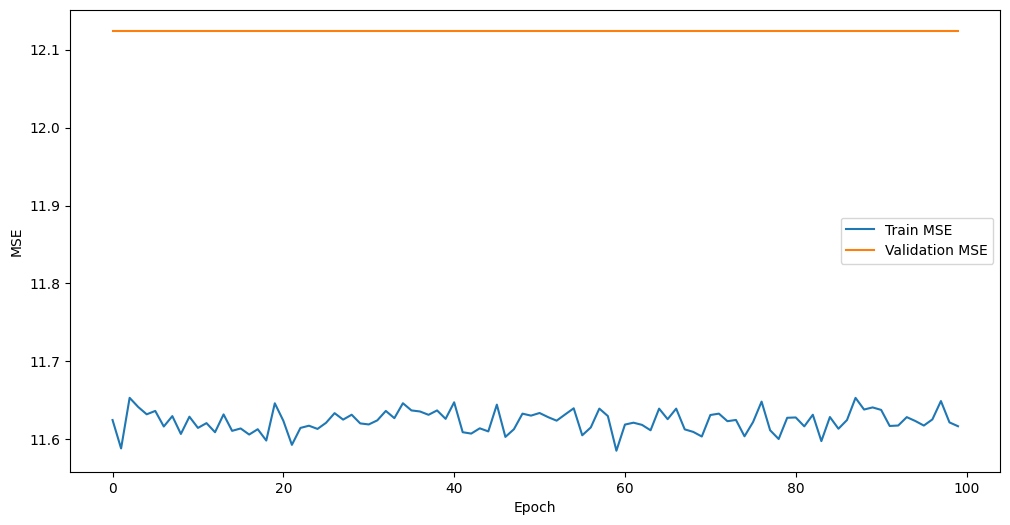

In [ ]:
model = SmallModel(input_dim, output_dim, alpha=0.1)

params = []
for layer in model.layers:
    if hasattr(layer, 'weight'):
        params.extend([layer.weight, layer.bias])

optimizer = SGD(params, lr=0.01, momentum=0.9)

train_losses = []
val_losses = []
epochs = 100

for epoch in range(epochs):
    model.train()
    y_pred = model.forward(X_train)
    loss = mse_loss(y_train, y_pred)
    train_losses.append(loss)

    grad_output = 2 * (y_pred - y_train) / y_train.shape[0]
    model.backward(X_train, grad_output)

    optimizer.step()
    optimizer.zero_grad()
    model.zero_grad()

    model.eval()
    y_val_pred = model.forward(X_val)
    val_loss = mse_loss(y_val, y_val_pred)
    val_losses.append(val_loss)


plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

Epoch 1/150
  Train Loss: 11.504324
  Val Loss: 11.966640
Epoch 11/150
  Train Loss: 11.559106
  Val Loss: 11.992061
Epoch 21/150
  Train Loss: 11.544469
  Val Loss: 11.970937
Epoch 31/150
  Train Loss: 11.534947
  Val Loss: 11.975457
Epoch 41/150
  Train Loss: 11.573422
  Val Loss: 11.966417
Epoch 51/150
  Train Loss: 11.564419
  Val Loss: 11.978542
Epoch 61/150
  Train Loss: 11.567567
  Val Loss: 11.965809
Epoch 71/150
  Train Loss: 11.569600
  Val Loss: 11.978338
Epoch 81/150
  Train Loss: 11.570210
  Val Loss: 11.978825
Epoch 91/150
  Train Loss: 11.577066
  Val Loss: 11.977626
Epoch 101/150
  Train Loss: 11.523953
  Val Loss: 11.984063
Epoch 111/150
  Train Loss: 11.546185
  Val Loss: 11.970675
Epoch 121/150
  Train Loss: 11.528586
  Val Loss: 11.971659
Epoch 131/150
  Train Loss: 11.542854
  Val Loss: 11.982524
Epoch 141/150
  Train Loss: 11.561481
  Val Loss: 11.973266


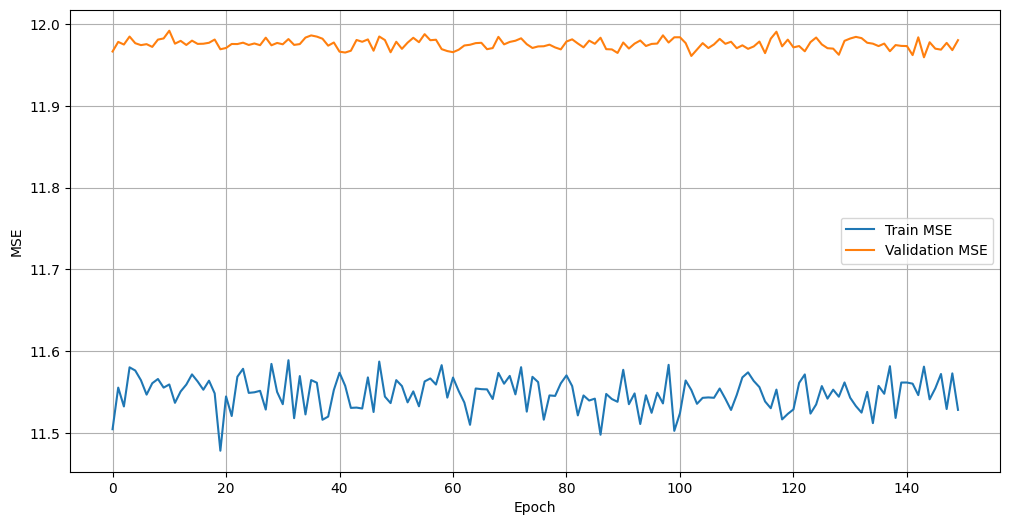

In [ ]:
from sklearn.preprocessing import StandardScaler

# Генерация более сложных данных для средней модели
np.random.seed(42)
input_dim = 50
output_dim = 3
n_samples = 5000

X = np.random.randn(n_samples, input_dim)
weights1 = np.random.randn(input_dim, 128) * 0.5
weights2 = np.random.randn(128, output_dim) * 0.3
bias = np.random.randn(output_dim)

matrix = np.tanh(X @ weights1 + np.random.randn(128)*0.1)
y = matrix @ weights2 + bias + 0.1 * np.random.randn(n_samples, output_dim)
y += 0.5 * np.sin(X[:, [0]] * 2) @ np.random.randn(1, output_dim)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

class MediumModel:
    def __init__(self, input_dim, output_dim, dropout_p=0.3):
        self.layers = [
            Linear(input_dim, 256),
            BatchNormalization(alpha=0.1),
            ReLU(),
            Dropout(dropout_p),

            Linear(256, 128),
            BatchNormalization(alpha=0.1),
            ReLU(),
            Dropout(dropout_p),

            Linear(128, output_dim)
        ]
        self.training = True

    def forward(self, x):
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = self.training
            x = layer.updateOutput(x)
        return x

    def backward(self, x, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.updateGradInput(layer.output if hasattr(layer, 'output') else x, grad_output)
        return grad_output

    def zero_grad(self):
        for layer in self.layers:
            if hasattr(layer, 'grad_weight'):
                layer.grad_weight.fill(0)
                layer.grad_bias.fill(0)
            if hasattr(layer, 'grad_gamma'):
                layer.grad_gamma.fill(0)
                layer.grad_beta.fill(0)
            if hasattr(layer, 'gradInput'):
                layer.gradInput.fill(0)

    def train(self):
        self.training = True
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = True

    def eval(self):
        self.training = False
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = False

model = MediumModel(input_dim, output_dim)

params = []
for layer in model.layers:
    if hasattr(layer, 'weight'):
        params.extend([layer.weight, layer.bias])
    if hasattr(layer, 'gamma'):
        params.extend([layer.gamma, layer.beta])

optimizer = SGD(params, lr=0.005, momentum=0.9)

train_losses = []
val_losses = []
epochs = 200

for epoch in range(epochs):
    model.train()
    y_pred = model.forward(X_train)
    loss = mse_loss(y_train, y_pred)
    train_losses.append(loss)

    grad_output = 2 * (y_pred - y_train) / y_train.shape[0]
    np.clip(grad_output, -1.0, 1.0, out=grad_output)

    model.backward(X_train, grad_output)

    for param in params:
        if hasattr(param, 'grad'):
            np.clip(param.grad, -0.5, 0.5, out=param.grad)

    optimizer.step()
    optimizer.zero_grad()
    model.zero_grad()

    model.eval()
    y_val_pred = model.forward(X_val)
    val_loss = mse_loss(y_val, y_val_pred)
    val_losses.append(val_loss)


# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Validation MSE')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()